In [1]:
from sklearn import datasets as ds
import pandas as pd
import numpy as np
import os, os.path
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.pyplot as plt
import colorsys
import copy
from PIL import Image

from sklearn.decomposition import KernelPCA
import zipfile

import skimage
from skimage import io

from skimage.transform import resize
from random import shuffle
import seaborn as sns

# Business Analysis

We are using a dataset from a Kaggle competition. The Nature Conservancy, whose mission is to "conserve the lands and waters on which all life depends." hopes we can detect which species of fish appears on a fishing boat, based on images captured from boat cameras at different angles. 

We eventually want to predict the likelihood of a fish species in a picture.

There are eight target categories in the dataset: Albacore tuna, Bigeye tuna, Yellowfin tuna, Mahi Mahi, Opah, Sharks, Other (meaning that there are fish present but not in the above categories), and No Fish (meaning that no fish is in the picture).

The images have only one fish in them, except small fishses (bait) are included with the fish to be identified.
This data is important because it can help with illegal fishing. The tuna in the data set are often illegally caught and unreported. The Nature Conservancy, in addition with other organizations, are creating a system of cameras that will scan a boat's catch and detect illegally caught fish. If we are able to accurately predict the fish we can aid in these efforts and reduce illegal fishing.
We know we will have gathered important information from this data set if we are able to detect the correct fish with an accuracy rate of over 80%. We found a paper where their accuracy was around 85% http://homepages.inf.ed.ac.uk/rbf/PAPERS/FinalCameraReadyVISAPP08.pdf but we will have to take into account images without fish, people or large objects appearing, and inclement weather. If we can achieve 80%, it would be a great foundation to build on. There will still be boats patrolling for illegal fishing. They will be able to personally look on the boat or the image for illegal fish if need be.

# Data Preparation

In [2]:
import glob2
from PIL import Image
import matplotlib.image as mpimg

fish_image_files = glob2.glob('train/**/*.jpg')
albacore_image_list = []
size = 300, 300


### Read Data as Numpy Arrays, Resize, and Recolor Black and White

In [3]:
igs = np.array([skimage.transform.resize(skimage.io.imread(fname, as_grey=True, plugin=None, flatten=None),(300,300))
                                         for fname in fish_image_files])

### Linearize and Visualize Images

In [4]:
train_data = igs.astype('float32')
train_data = train_data / 255
igs_pca = train_data.reshape(igs.shape[0], (train_data.shape[1]*train_data.shape[2]))

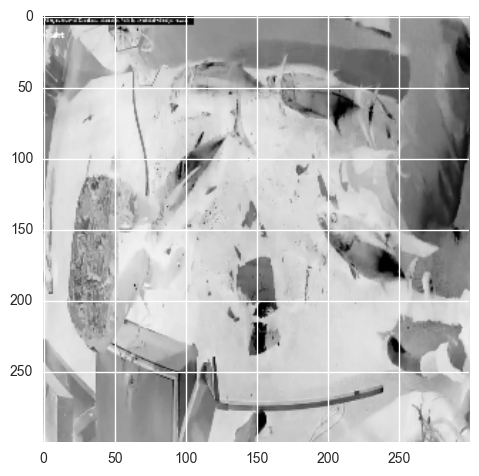

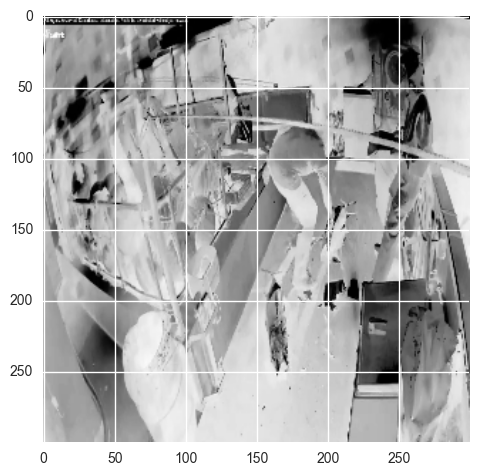

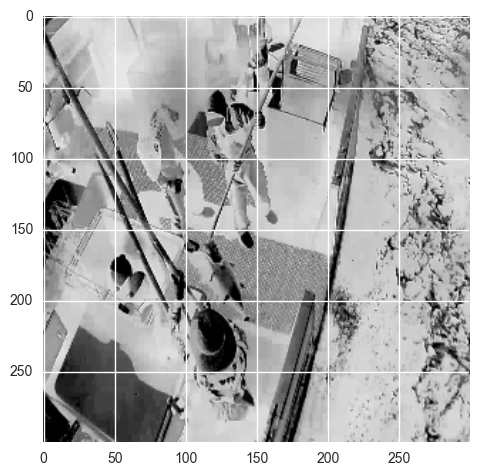

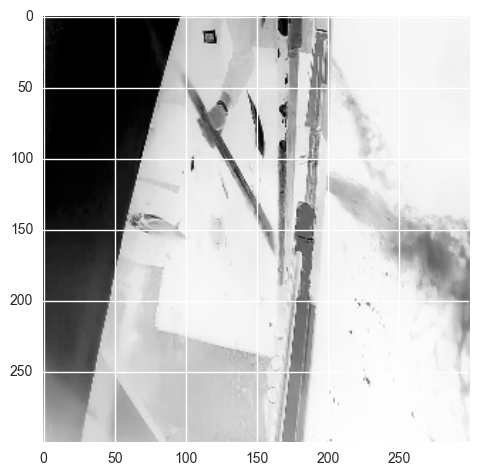

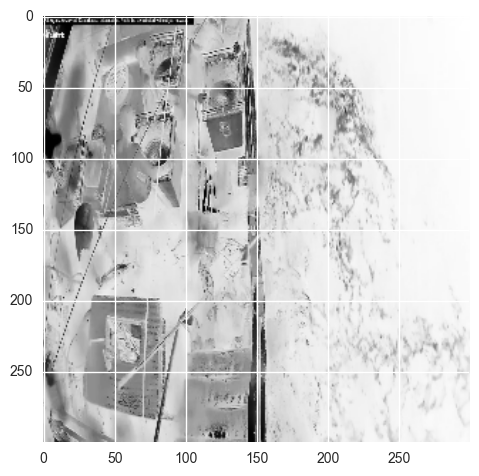

In [5]:
for i in range(0,5):
    plt.imshow(igs[i])
    plt.show()

# Data Reduction

### Linear Dimensionality Reduction Using Principal Component Analysis

In [6]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 173
print ("Extracting the top %d eigenfishes from %d fishes" % (
    n_components, igs_pca.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(igs_pca)
eigenfaces = pca.components_.reshape((n_components, train_data.shape[1]*train_data.shape[2]))

Extracting the top 173 eigenfishes from 3777 fishes
CPU times: user 5min 11s, sys: 22.8 s, total: 5min 34s
Wall time: 1min 57s


In [ ]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
        

In [ ]:
plot_explained_variance(pca)

Approximately 180 dimensions are required to adequately represent our image data. 

### Non-Linear Dimensionality Reduction 

In [ ]:
n_components = 173
print ("Extracting the top %d eigenfishes from %d fishes" % (n_components, igs.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=15) # very sensitive to the gamma parameter
%time kpca.fit(igs_pca)


In [ ]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

from ipywidgets import widgets  # make this interactive!
# compare the different methods
X = igs_pca
n_samples, n_features = igs_pca.shape
def plt_reconstruct(idx_to_reconstruct):
    idx_to_reconstruct = np.round(idx_to_reconstruct)
    
    reconstructed_image = pca.inverse_transform(pca.transform(X[idx_to_reconstruct]))
    reconstructed_image_kpca = kpca.inverse_transform(kpca.transform(X[idx_to_reconstruct]))
    
    
    plt.figure(figsize=(15,7))
    
    plt.subplot(1,4,1)
    plt.imshow(X[idx_to_reconstruct].reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.grid()
    
    plt.subplot(1,4,2)
    plt.imshow(reconstructed_image.reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.title('Full PCA')
    plt.grid()
    
    plt.subplot(1,4,3)
    plt.imshow(reconstructed_image_kpca.reshape((train_data.shape[1], train_data.shape[2])), cmap=plt.cm.gray)
    plt.title('Kernel PCA')
    plt.grid()
    plt.show()


In [ ]:
widgets.interact(plt_reconstruct,idx_to_reconstruct=(0,n_samples-1,1),__manual=True)

We prefer non-linear dimensions to linear dimensions primarily because of the higher clarity and shorter execution time (Kernel principal component analysis took 35% of the time that it took for linear principal component analysis). 

### Feature Extraction Techniques

In [ ]:
from skimage.io import imshow

idx_to_reconstruct = int(np.random.rand(1)*len(X))
img  = X[idx_to_reconstruct].reshape((train_data.shape[1], train_data.shape[2]))
imshow(img)
plt.grid()
plt.show()

#### Ordered Gradients

In [ ]:
from skimage.filters import sobel_h, sobel_v

gradient_mag = np.sqrt(sobel_v(img)**2 + sobel_h(img)**2 ) 
imshow(gradient_mag)
plt.grid()
plt.show()

There is a fish hanging from the reel discernable in the gradients diagram. The curves that are highlighted in this gradients plot could help locate the fish more easily amongst the busy background. 

#### DAISY Bag of Features Model

In [ ]:
from skimage.feature import daisy

features, img_desc = daisy(img,step=40, radius=10, rings=3, histograms=5, orientations=8, visualize=True)
imshow(img_desc)
plt.grid()
plt.show()

Daisy uses a bag of features model. The image we see here is black, and we have not been able to figure out why. The image shows 
a symmetrical distribution of rings so we conclude that no recognition is truly happening. It does not appear to be an appropriate feature extraction technique for us.

In [ ]:
features = daisy(img,step=10, radius=10, rings=2, histograms=4, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

In [ ]:
from ipywidgets import fixed
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Original Image ")
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Closest Image  ")
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((train_data.shape[1], train_data.shape[2])))
    plt.title("Next Closest Image ")
    plt.grid()
    plt.show()

In [ ]:
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=6, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[3],(train_data.shape[1], train_data.shape[2]))

In [ ]:
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (train_data.shape[1], train_data.shape[2]))
print(daisy_features.shape)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

In [ ]:
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

The Daisy feature extraction helps group pictures in our dataset that have the same general background. 

#### Gabor Filters

In [ ]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(4):
    theta = theta / 4. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(X))

gabr_feature = compute_gabor(X[idx_to_reconstruct], kernels, ((train_data.shape[1], train_data.shape[2])))
gabr_feature

In [ ]:
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, X, kernels, (train_data.shape[1], train_data.shape[2]))
print(gabor_stats.shape)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances
%time dist_matrix = pairwise_distances(gabor_stats)

In [ ]:
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

### Visualizing Differences in Target Classes

In [ ]:
plt.imshow(dist_matrix)
plt.colorbar()
plt.grid(False)
plt.show()


This heatmap shows that there seems to be higher correlation around the images numbered 6000. There are also some darker lines between 2000 and 3000 and at 2500 which indicate possible correlation and clusters of rows with similar values. However overall, the squares along the diagonal do not indicate any major clustering. That is, except for the white diagonal line, where the same images on the x and y match up, as should be expected considering we read them in order. The features are read and maintained in the matrix in this order: ALB (Albacore Tuna), BET (Bigeye Tuna), DOL (Dolphinfish), LAG (Oopah/ Moonfish), NoF (no fish), OTHER, SHARK (various including the silky and Shortkin M), and YFT (YellowFish Tuna).

# Exceptional Work

In [ ]:
transformed_pca = pca.transform(igs_pca)

import pandas as pd
from pandas.tools.plotting import scatter_plot

dataframe = pd.DataFrame(transformed_pca)
dataframe['pca_avg'] = dataframe.mean(axis=1)
dataframe['pca_min'] = dataframe.min(axis=1)
dataframe['pca_max'] = dataframe.max(axis=1)

dataframe.plot(kind='scatter', x='pca_max', y='pca_min', c="orange")
plt.show()